# Super rezolucija slika


## Uvod
Za povećavanje rezolucije slika postoje mnogi efikasni algoritmi kao što su bilinearna, bikubna, Lanczos-ova interpolacija, te interpolacija metodom najbližih susjeda. Ovi algoritmi dobro rekonstruiraju zaglađena područja na slici međutim ne uspjevaju rekonstruirati rubove jakih gradijenata kao niti fine detalje u područjima velikih promjena

Krentu ćemo od jednog od ovih efikasnih algoritama, te ćemo metodama dubokih neuronskih mreža (ne tako efikasno) pokušati popraviti kvalitetu uvećane slike. Uspješnost ćemo mjeriti standarnim metrikama za kvalitetu rekonstrukcije slika (PSNR i SSIM) te vizulano.

## Potrebni dodatni paketi:
> tensorflow >=1.4


## SR metodama dubokih neuronskih mreža
Klasični pristup problemu super rezolucije slika metodama dubokih neuronskih mreža podrazumijeva velik broj parova slika visoke rezolucije i njima pripadnih slika niske rezolucije. Takve parove dobivamo tako da proizvoljnu sliku proglasimo slikom visoke rezolucije te na nju primjenimo neki opertor smanjena razlučivosti (npr. bilinearan, bikubni, Lanczos-ov, najbližih susjeda) kako bi dobili sliku manje rezolucije. Potom algoritmom unazadne propagacije (engl. backpropagation) učimo potpuno konvolucijsku neuronsku mrežu mapirati slike niske rezolucije u njima pripadne slike visoke rezolucije. Tako naučenu mrežu  možemo primjeniti na proizvoljnu sliku (koja dolazi iz iste distribucije kao i skup slika na kojima je mreža učena) kako bi joj povečali ralučivost.


## Zero-shot SR
Ovdje ćemo implementirati pristup iz rada [1]. Glavna ideja je sljedeća: za danu sliku X koju želimo uvećati, mi ćemo smanjiti rezoluciju slike X te je potom povećati nekom brzom ali manje kvalitetnom metodom zatim naučiti konvolucijsku neurosnku mrežu da mapira sliku lošije kvalitete u polaznu sliku X. Tako naučenu mrežu primijenti ćemo na sliku X uvećanu nekom od gore navedenih interpolacijskih metoda kako bi u konačnici dobili sliku bolje kvalitete.




In [147]:
import numpy as np
import tensorflow as tf
from PIL import Image as PImage

tf.reset_default_graph()

In [148]:
# Konstante
############

# Image konstante:
CROP_SIZE = 128

# Train konstante:
TRAIN_STEPS = 190
SHOW_STEPS = 3

In [149]:
from random import shuffle, choice
import PIL

def normalize(image):
    """[0, 255] --> [-1, 1]"""
    image /= 127.5
    image -= 1.
    return image

def denormalize(image):
    """[-1, 1] --> [0, 255]"""
    image += 1
    image *= 127.5
    return np.clip(image, 0., 255.)


def generate_transformed_images(image):
    alpha = [0, 90, 180, 270]
    flip_flag = [True, False]
    
    transformation = [(angle, flip) for flip in flip_flag for angle in alpha]
    
    angle = choice(alpha)
    flip = choice(flip_flag)
    
    img = image.copy()
    img = img.rotate(angle)
    img = img.transpose(method=PIL.Image.FLIP_LEFT_RIGHT) if flip else img
    
    return img
    

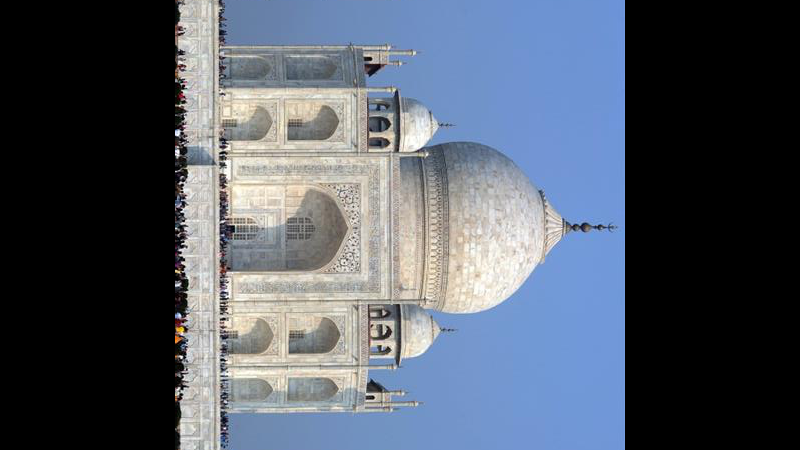

In [150]:
img = generate_transformed_images(img)
img


In [159]:
def data_generator(image, steps=2, use_image_shape=False):
    
    height = image.height
    width = image.width
    
    assert height >= CROP_SIZE and width >= CROP_SIZE, \
        f'(H, W) = ({height}, {width}) with crop_size = {CROP_SIZE}'
        
    upper_left_y_range = height - CROP_SIZE
    upper_left_x_range = width - CROP_SIZE
    
    def generator(upper_y, upper_x):
        done_steps = 0
        
        while done_steps < steps:
            upper_left_y = np.random.randint(1, upper_y + 1)
            upper_left_x = np.random.randint(1, upper_x + 1)
            
            img_hr = image.copy()
            # box = (left, upper, right, lower)
            img_hr = img_hr.crop(box=(upper_left_x, upper_left_y, \
                                      upper_left_x + CROP_SIZE, upper_left_y + CROP_SIZE))
            
            img_hr = generate_transformed_images(img_hr)
            img_lr = img_hr.copy()
            img_lr = img_lr.resize((width//2, height//2)) if use_image_shape \
                    else img_lr.resize((CROP_SIZE//2, CROP_SIZE//2))
            img_lr = img_lr.resize((width, height)) if use_image_shape \
                    else img_lr.resize((CROP_SIZE, CROP_SIZE))

            
            img_hr = normalize(np.array(img_hr, dtype=np.float32))
            img_lr = normalize(np.array(img_lr, dtype=np.float32))
            
            done_steps += 1
            
            yield img_hr, img_lr
        
#         raise StopIteration() # deprecated from Python 3.5
        return
        
    return generator(upper_y=upper_left_y_range,
                     upper_x=upper_left_x_range)
    

def batch_generator(image, steps, batch_size=4):
    done = 0
    batch_img_hr = []
    batch_img_lr = []
    
    while True:
        
        for img_hr, img_lr in data_generator(image):
            batch_img_hr.append(img_hr[np.newaxis])
            batch_img_lr.append(img_lr[np.newaxis])

            if len(batch_img_hr) == batch_size:
                yield np.concatenate(batch_img_hr, axis=0), \
                      np.concatenate(batch_img_lr, axis=0)
                batch_img_hr = []
                batch_img_lr = []
                done += 1
                
                if done >= steps:
                    return
                
    
    

In [160]:
p = [a for a in batch_generator(img, steps=4)]

In [161]:
def net_arch(x, filters=64, kernel_size=3):
    
    x = tf.layers.conv2d(x, filters, kernel_size, padding='SAME', activation=tf.nn.relu)
    x = tf.layers.conv2d(x, filters, kernel_size, padding='SAME', activation=tf.nn.relu)
    x = tf.layers.conv2d(x, filters, kernel_size, padding='SAME', activation=tf.nn.relu)
    x = tf.layers.conv2d(x, filters, kernel_size, padding='SAME', activation=tf.nn.relu)
    x = tf.layers.conv2d(x, filters, kernel_size, padding='SAME', activation=tf.nn.relu)
    x = tf.layers.conv2d(x, filters, kernel_size, padding='SAME', activation=tf.nn.relu)
    x = tf.layers.conv2d(x, filters, kernel_size, padding='SAME', activation=tf.nn.relu)
    x = tf.layers.conv2d(x, 3, kernel_size, padding='SAME', activation=None)
    
    return x

In [162]:

# define input
x = tf.placeholder(dtype=tf.float32, shape=(None, None, None, 3), name='input')
gt = tf.placeholder(dtype=tf.float32, shape=(None, None, None, 3), name='target')


residual = net_arch(x)
prediction = tf.add(x, residual)
loss = tf.norm(tf.subtract(prediction, gt), ord=1)


optimizer = tf.train.AdamOptimizer(learning_rate=0.0003)
train_op = optimizer.minimize(loss)


In [ ]:
# get image
image_path = 'pattern_1.jpg'
train_image = PImage.open(image_path)


# with tf.Session() as sess:
sess = tf.InteractiveSession()
    
sess.run(tf.global_variables_initializer())

losses = []

# train loop
for step, (hr_batch, lr_batch) in enumerate(batch_generator(train_image, steps=TRAIN_STEPS)):
    sess.run(train_op, feed_dict={x:lr_batch, gt:hr_batch})
    loss_value = sess.run(loss, feed_dict={x:lr_batch, gt:hr_batch})
    losses.append(loss_value)

    if (step+1) % SHOW_STEPS == 0:
        print(f'Step [{step+1}], loss = {loss_value}')

print('END')

Step [3], loss = 67400.921875


In [ ]:
plt.plot(losses)

In [ ]:

test_image = PImage.open(image_path)
test_image = test_image.resize((test_image.width * 2, test_image.height * 2))
lr_image = test_image.copy()
# lr_image = lr_image.resize((lr_image.width//2, lr_image.height//2))
# lr_image = lr_image.resize((test_image.width, test_image.height))

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(test_image)

plt.subplot(1, 2, 2)
plt.imshow(lr_image)

In [ ]:
test_image

In [ ]:
lr_image

In [ ]:
lr_normalized = normalize(np.array(lr_image, dtype=np.float32))
hr_normalized = sess.run(prediction, feed_dict={x:lr_normalized[np.newaxis]})
# print(np.max(hr_normalized))
# print(hr_normalized)
hr = np.array(denormalize(hr_normalized), dtype=np.uint8)
# print(np.max(hr))

hr_image = PImage.fromarray(np.squeeze(hr, axis=0))
hr_image
    

In [ ]:
hr_image.show()

In [ ]:
test_image = test_image.resize((test_image.width * 2, test_image.height * 2))
hr_image = test_image.resize((hr_image.width * 2, hr_image.height * 2))

hr_normalized = normalize(np.array(hr_image, dtype=np.float32))
hhr_normalized = sess.run(prediction, feed_dict={x:hr_normalized[np.newaxis]})

hhr = np.array(denormalize(hhr_normalized), dtype=np.uint8)
hhr_image = PImage.fromarray(np.squeeze(hhr, axis=0))

In [ ]:
test_image.show()

In [ ]:
np.mean((normalize(np.array(hr_image,dtype=np.float32)) \
         - normalize(np.array(lr_image,dtype=np.float32)))**2)

In [ ]:
from skimage.measure import structural_similarity as ssim

def psnr(original_image, reconstructed_image):
    original_image = np.array(original_image, dtype=np.float32)
    reconstructed_image = np.array(reconstructed_image, dtype=np.float32)
    
    maxI = np.max(original_image)
    mse = np.mean(np.square(original_image - reconstructed_image))
    return 20 * np.log10(maxI / np.sqrt(mse))



In [ ]:
Reference:
[1] “Zero-Shot” Super-Resolution using Deep Internal Learning